In [1]:
pip install ncc

Note: you may need to restart the kernel to use updated packages.


In [15]:
from PIL import Image,ImageDraw
import numpy as np
import math
from scipy import signal
import ncc

import matplotlib.pyplot as plt
from scipy.ndimage import filters

# 1.2
The first task is to build a scaled representation of the input image. Create a routine pyramid = MakeGaussianPyramid(image, scale, minsize) that creates a pyramid for an image. It returns a list including the original PIL image followed by all the PIL of images of reduced size, using a scale factor of 0.75 from one level to the next. The pyramid should stop when any further reduction in size will make the larger dimension of the image smaller than minsize, where minsize is an integer. If image is a PIL image, you can use the Python function im.resize((int(x*scale),int(y*scale)), Image.BICUBIC) to reduce the image size at each step. Note: You should also filter the image with a Gussian whos sigma is 1/(2*scale) to avoid antialising artifacts. You can use the code from previous assignment to do this filtering or use scipy.ndimage.gaussian_filter.

You can choose to represent the pyramid as a list of 3d floating point numpy arrays, instead of the list of PIL images. This would ensure representational consistancy with respect to Laplacian pyramid which we will need to build in Part 2 of the assignment and, in fact, maybe slightly more convinent overall. Both representations will be acceptable for full credit. However, you do need to consistenly account for one representation or the other in the display routines and the rest of the code.

Note that while for this part it is sufficent to deal with greyscale images, in Part 2 of the assignment will require you to deal with color images, so it maybe worwhile making sure that this function works for color images as well as greyscale. Make sure you are filtering the RGB colour channels separately and then composing them into a 3d array to store.

In [49]:
# from A1
def blur(image, sigma):
    image = image.convert('RGB')
    array = np.asarray(image)
    r = array[:,:,0].astype("int")
    g = array[:,:,1].astype("int")
    b = array[:,:,2].astype("int")
    filter_r = filters.gaussian_filter(r,sigma)
    filter_g = filters.gaussian_filter(g,sigma)
    filter_b = filters.gaussian_filter(b,sigma)
    
    filtered = np.dstack((filter_r,filter_g,filter_b)).astype(np.uint8) # stacks 3 h x w arrays -> h x w x 3(from stackoverflow)
    img = Image.fromarray(filtered)
    return img

def MakeGaussianPyramid(image, scale, minsize):
    # build pyramid
    pyramid = [image]
    # get the size of image to check
    (x,y) = image.size 
    size = min(x,y)
    img = image
    # check if size is larger than minsize(minsize is not area)
    while size >= minsize:
        # blur for r,g,b
        img = blur(img,1/(2*scale))
        # resize
        (x,y) = img.size 
        img = img.resize((int(x*scale),int(y*scale)), Image.BICUBIC)
        size = size * scale
        pyramid.append(img)
    
    return pyramid
# scale is 0.75

# 1.3
In order to check your pyramid, write a routine ShowGaussianPyramid(pyramid) that will join all the images in the pyramid into one horizontal image and display this result with imshow.

You can combine multiple images into a single image by first creating a blank image of the right size image = Image.new("L", (width, height)) and then pasting existing images into it image.paste(im,(offset_x,offset_y)). Since you will be handing in a PDF version of your pyramids, feel free to initialize unused space with white (rather than black). This will make it look cleaner in the PDF.

Note that while for this part it is sufficent to deal with greyscale images, in Part 2 of the assignment will require you to deal with color images, so it maybe worwhile making sure that this function works for color images as well as greyscale.

In [50]:
def ShowGaussianPyramid(pyramid):
    # first img is largest
    height = pyramid[0].size[1]
    # width is all imgs in list
    width = 0
    for img in pyramid:
        width += img.size[0]
    
    image = Image.new("RGB", (width, height),"white")
    # paste each imgs in background
    # initial the x coordinate 
    #(only x , since the point is left corner)
    x = 0
    for img in pyramid:        
        image.paste(img,(x,0))
        width = img.size[0]
        x += width
    
    # imshow
    plt.imshow(image)
    return None

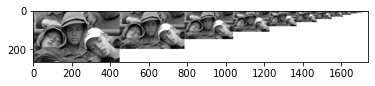

In [54]:
fans = Image.open('fans.jpg')
img = MakeGaussianPyramid(fans, 0.75, 10)
ShowGaussianPyramid(img)

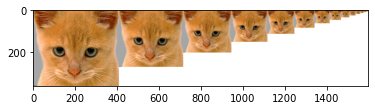

In [55]:
cat = Image.open('0a_cat.bmp')
img = MakeGaussianPyramid(cat, 0.75, 10)
ShowGaussianPyramid(img)

In [52]:
# for fun (why "L" for exapmle in background, really scary.....)
def FunShowPyramid(pyramid):
    # first img is largest
    height = pyramid[0].size[1]
    # width is all imgs in list
    width = 0
    for img in pyramid:
        width += img.size[0]
    
    image = Image.new("L", (width, height),"white")
    # paste each imgs in background
    # initial the x coordinate 
    #(only x , since the point is left corner)
    x = 0
    for img in pyramid:        
        image.paste(img,(x,0))
        width = img.size[0]
        x += width
    
    # imshow
    plt.imshow(image)
    return None


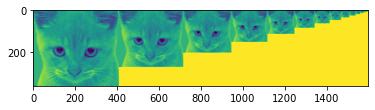

In [53]:
cat = Image.open('0a_cat.bmp')
img = MakeGaussianPyramid(cat, 0.75, 10)
FunShowPyramid(img)
# really scary ! 555555....

# 1.4
To match a template to a pyramid, write a function FindTemplate(pyramid, template, threshold) that will find and mark all locations in the pyramid at which the normalized cross correlation (NCC) of the template with the image is above the threshold. The goal is to achieve results similar to those on the right, although they will differ depending on the threshold you choose.

1. Reduce the width to 15 pixels, proportionally scaling the height so the aspect ratio is maintained with scaling, using imresize with bicubic interpolation.
2. For each pixel at which the normalized correlation result is above the threshold, draw lines (forming a rectangle) to mark the boundary of the template at that location. To draw lines in a PIL image, use the routine draw.line in the ImageDraw module. For example, if im is a PIL image

In [169]:
def FindTemplate(pyramid, template, threshold):
    # resize the template
    ratio = template.size[0]/template.size[1]
    template = template.resize((15,int(15/ratio)), Image.BICUBIC)
                    
    matches = []
    for img in pyramid:
        img = img.convert('L')
        # find each pixel at which the normalized correlation result is above the threshold
        pos = np.where(ncc.normxcorr2D(img,template) > threshold)
        # combine with zip
#         print(pos)
        matches.append(zip(pos[1],pos[0]))
        
    
    img = pyramid[0].convert('RGB')
    width = template.size[0]
    height = template.size[1]
    x1=0
    x2=0
    y1=0
    y2=0
    for i in range(len(matches)):
        scale = 0.75 ** i
        for pos in matches[i]:
            # pos is center 
            # left is x0, right is x1, up is y0, down is y1
            x1 = (pos[0]/scale) - ((width/2)/scale)
            x2 = (pos[0]/scale) + ((width/2)/scale)
            y1 = (pos[1]/scale) - ((height/2)/scale)
            y2 = (pos[1]/scale) + ((height/2)/scale)
            draw = ImageDraw.Draw(img)
            draw.line((x1,y1,x1,y2),fill="red",width=2)
            draw.line((x1,y1,x2,y1),fill="red",width=2)
            draw.line((x2,y1,x2,y2),fill="red",width=2)
            draw.line((x1,y2,x2,y2),fill="red",width=2)
            del draw
    return img

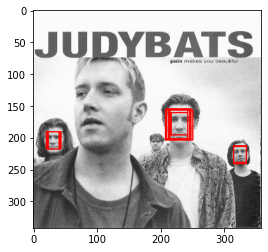

In [172]:
judybats = Image.open('judybats.jpg')
template = Image.open('template.jpg')
img = MakeGaussianPyramid(judybats, 0.75, 10)
img2 = FindTemplate(img, template, 0.68)
plt.imshow(img2)

# 1.5
Once your code is working, adjust the threshold to achieve close to an equal error rate on the six given images (judybats, students, tree, family, fans, sports) considered together. Note, there should be one single threshold that works well, albeit not perfectly, for all images (NOT a threshold per image). An equal error rate is where the number of non-faces seen as faces (false positives) equals the number of missed faces (false negatives). You can do this by just trying different thresholds and counting the number of non-faces seen as faces and the number of missed faces.

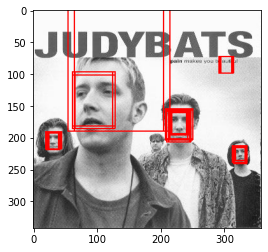

In [177]:
judybats = Image.open('judybats.jpg')
template = Image.open('template.jpg')
img = MakeGaussianPyramid(judybats, 0.75, 10)
img2 = FindTemplate(img, template, 0.6)
plt.imshow(img2)

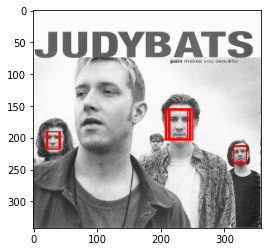

In [178]:
judybats = Image.open('judybats.jpg')
template = Image.open('template.jpg')
img = MakeGaussianPyramid(judybats, 0.75, 10)
img2 = FindTemplate(img, template, 0.7)
plt.imshow(img2)

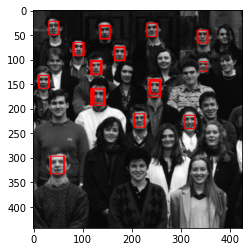

In [209]:
students = Image.open('students.jpg')
template = Image.open('template.jpg')
img = MakeGaussianPyramid(students, 0.75, 10)
img2 = FindTemplate(img, template, 0.7)
plt.imshow(img2)

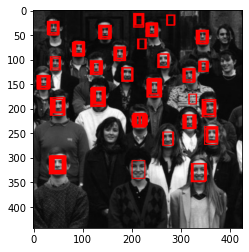

In [211]:
students = Image.open('students.jpg')
template = Image.open('template.jpg')
img = MakeGaussianPyramid(students, 0.75, 10)
img2 = FindTemplate(img, template, 0.55)
plt.imshow(img2)

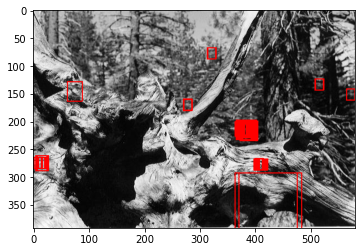

In [185]:
tree = Image.open('tree.jpg')
template = Image.open('template.jpg')
img = MakeGaussianPyramid(tree, 0.75, 10)
img2 = FindTemplate(img, template, 0.52)
plt.imshow(img2)

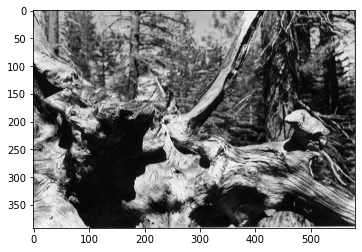

In [201]:
tree = Image.open('tree.jpg')
template = Image.open('template.jpg')
img = MakeGaussianPyramid(tree, 0.75, 10)
img2 = FindTemplate(img, template, 0.7)
plt.imshow(img2)

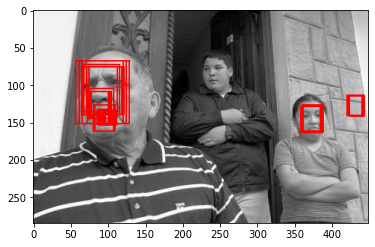

In [195]:
family = Image.open('family.jpg')
template = Image.open('template.jpg')
img = MakeGaussianPyramid(family, 0.75, 10)
img2 = FindTemplate(img, template, 0.55)
plt.imshow(img2)

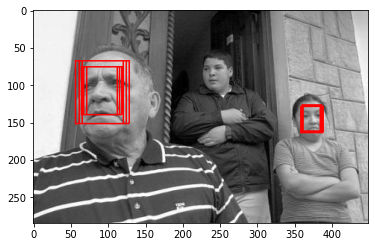

In [193]:
family = Image.open('family.jpg')
template = Image.open('template.jpg')
img = MakeGaussianPyramid(family, 0.75, 10)
img2 = FindTemplate(img, template, 0.57)
plt.imshow(img2)

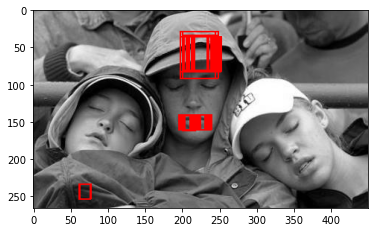

In [198]:
fans = Image.open('fans.jpg')
template = Image.open('template.jpg')
img = MakeGaussianPyramid(fans, 0.75, 10)
img2 = FindTemplate(img, template, 0.6)
plt.imshow(img2)

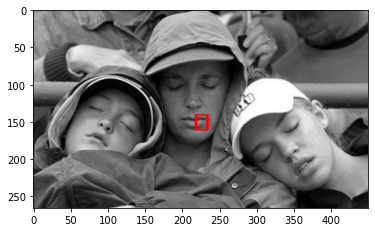

In [204]:
fans = Image.open('fans.jpg')
template = Image.open('template.jpg')
img = MakeGaussianPyramid(fans, 0.75, 10)
img2 = FindTemplate(img, template, 0.65)
plt.imshow(img2)

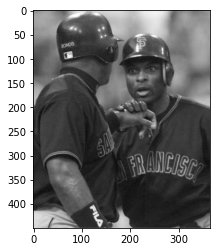

In [205]:
sports = Image.open('sports.jpg')
template = Image.open('template.jpg')
img = MakeGaussianPyramid(sports, 0.75, 10)
img2 = FindTemplate(img, template, 0.65)
plt.imshow(img2)

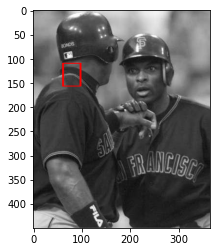

In [208]:
sports = Image.open('sports.jpg')
template = Image.open('template.jpg')
img = MakeGaussianPyramid(sports, 0.75, 10)
img2 = FindTemplate(img, template, 0.6)
plt.imshow(img2)
#lol.....0.65 is better

# Conclusion: 
By counting the missing faces and non-faces, it turns out that when the faces are more, smaller threshold (0.55~0.65) is better, while when the face is not really recognizable or in general, 0.7 is the best choice, since less may cause non-faces, larger may cause missing faces.

# 1.6
Answer: Since recall is a factor measures the completeness or correctness of result. In this program, recall is (the real faces detected(exclude the non-face))/(total faces+missing face)->(positive/negative+positive)
judybats:0.6, students:0.91, tree:0, family:0.67, fans:0, sports:0
Some are really low, some because there are no face in the image,some are due to the low similarity with the template image, maybe the person back to the camara,maybe they are the foreign, or they may wear hats or something. All of that affect the rate, since the only compared image is template which is fixed and limited to help the program recognize all faces

# 2.2
The first task is to build a Laplacian scaled representation of the two input images loaded from orchard.jpg and violet.jpg shown below. Note that these are taken with differet focal length setting on the camera, so while the scene is identical only one of the plants is in focus (either the one in front or the one in the back).
Create a routine pyramid = MakeLaplacianPyramid(image, scale, minsize) that creates a Laplacian pyramid for an image. It should return a list of ``images'' including the Laplacian at a resolution of the original image, followed by all the Laplacian ``images'' of reduced size, using a scale factor of 0.75 from one level to the next. IMPORTANT: pyramid should be represented as a list of 3d numpy arrays, where the first two dimensions correspond to resplution at the givel level and the last dimension is 3, corresponding to color channels. The pyramid should stop when any further reduction in size will make the larger of the spatial dimensions of the image smaller than minsize. The easiest way to construct a Laplacian pyramid is by first constructing a Gaussian one (re-use MakeGaussianPyramid function from Part 1 ensuring that it works for RGB image inputs) and then taking differences of Gaussian pyramid levels and their smoothed variants. Note: The highest level (lowest resolution) of both Gaussian and Laplacian pyramid is the same and both pyramids should have the same numeber of levels.



In [464]:
def MakeLaplacianPyramid(image, scale, minsize):
    image = Image.open(image)
    GaussPy = MakeGaussianPyramid(image, scale, minsize)
    (x,y) = image.size 
    size = min(x,y)
    
    LaplaPy = []
    # check if size is larger than minsize(minsize is not area)
    while size >= minsize:
        image = image.convert('RGB')
        array = np.asarray(image)
        r = array[:,:,0].astype("int")
        g = array[:,:,1].astype("int")
        b = array[:,:,2].astype("int")
        
        # gaussian filter first
        filter_r = filters.gaussian_filter(r,1/(2*scale))
        filter_g = filters.gaussian_filter(g,1/(2*scale))
        filter_b = filters.gaussian_filter(b,1/(2*scale))
       
        # then smooth
        tf_r = filters.gaussian_filter(filter_r,1/(2*scale))
        tf_g = filters.gaussian_filter(filter_g,1/(2*scale))
        tf_b = filters.gaussian_filter(filter_b,1/(2*scale))
        smooth = np.dstack((tf_r,tf_g,tf_b)).astype(np.uint8) # stacks 3 h x w arrays -> h x w x 3(from stackoverflow)
        
        # substract smooth from orignal
        sub_r = np.clip((filter_r - tf_r),0,255)
        sub_g = np.clip((filter_g - tf_g),0,255)
        sub_b = np.clip((filter_b - tf_b),0,255)
        
        # append in LaplaPy
        rgb = np.dstack((sub_r,sub_g,sub_b)).astype(np.uint8)
        LaplaPy.append(rgb)
        
        # update image
        smoothimg = Image.fromarray(smooth)
        (x,y) = smoothimg.size
        image = smoothimg.resize((int(x*scale),int(y*scale)), Image.BICUBIC)
        size = size*scale
        
    last = np.asarray(GaussPy[-1]).astype(np.uint8)
    LaplaPy.append(last)
    return LaplaPy

# 2.3
In order to check your pyramid, write a routine ShowLaplacianPyramid(pyramid) that will join all the images in the pyramid into one image and display this result with imshow. The arrangement of layers and most of the code should reamble Gaussian pyramid in Part 1; unlike Part 1, however, you will need to deal with RGB images. Further, you should be careful when displaying Laplacyan pyramids as all but the last level will contain values in the range -128 to 128 if you are working with image pixels in 0 to 255 range (or between -0.5 and 0.5 if you normalized the range to 0 to 1). Hence you will need offset (and possibly scale) the levels before displaying, similar to what you did for a high-pass filtered images in Assignment 1. In effect your display function should add 128 (or 0.5) to all levels, except for the lowest one, require you to clip resulting values and convert to unit8. Do NOT add offset to Laplacian in the function that computes it, only in the display function. Since you will be handing in a PDF version of your pyramids, feel free to initialize unused space with white (rather than black). This will make it look cleaner in the PDF. Visualize Laplacian pyramid for both orchard.jpg and violet.jpg images.

In [465]:
def  ShowLaplacianPyramid(pyramid):  
    first = Image.fromarray(pyramid[0].astype(np.uint8))
    # first img is largest
    height = first.size[1]
    # width is all imgs in list
    width = 0
    # turn it to imgarray first
    imgarray = []
    for a in pyramid:
        img = Image.fromarray(a.astype(np.uint8))
        imgarray.append(img)
    #cal the width
    for img in imgarray:
        width += img.size[0]
    
    image = Image.new("RGB", (width, height),"white")
    # paste each imgs in background
    # initial the x coordinate 
    #(only x , since the point is left corner)
    
    x = 0
    i = 0
    for img in pyramid:  
        if i != len(pyramid)-1:
            img = np.add(img,np.full(img.shape,128))
        img = np.clip(img,0,255)
        img = img.astype(np.uint8)
        img = Image.fromarray(img)
        image.paste(img,(x,0))
        width = img.size[0]
        x += width
        i +=1
    
    # imshow
    plt.imshow(image)
    return None

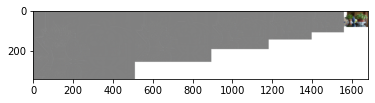

In [466]:
o = MakeLaplacianPyramid('orchid.jpg',0.75,100)
ShowLaplacianPyramid(o)

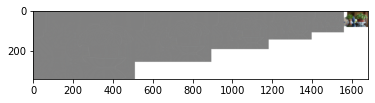

In [467]:
v = MakeLaplacianPyramid('violet.jpg',0.75,100)
ShowLaplacianPyramid(v)

# 2.4
Buld a function that takes a Laplacian pyramid and reconstructs Gaussian pyramid of that image from a Laplacian one, gPyramid = ReconstructGaussianFromLaplacianPyramid(lPyramid). The procedure is recursive. You start from the highest level of the Laplacian pyramid (smallest resolution) upsample it to match the resolution of the next level and add that level to the upsampled version to obtain a corresponding Gaussian level. You can use im.resize((width,height), Image.BICUBIC) to carry out upsampling. Note: The last level of the Laplacian pyramid is a small resolution image, same as in Gaussian pyramid, so that level can be just coppied over. Use ShowGaussianPyramid(pyramid) function from Part 1 to visualize the two reconstructed Gaussian pyramids to ensure the function is working.

In [468]:
def ReconstructGaussianFromLaplacianPyramid(lPyramid):
    gPyramid = []
    
    lastarray = lPyramid[-1]
    img = Image.fromarray(lastarray.astype(np.uint8))
    # plan to add from the tail to the head, then reverse
    gPyramid.append(img)
    a = len(lPyramid)-1
    
    while a != 0:
        image_array = lPyramid[a-1]
        # do the things back
        #resize
        image = Image.fromarray(image_array.astype(np.uint8))
        (width,height) = image.size
        image = img.resize((width,height), Image.BICUBIC)
        # color channel back: add next level
        image = image.convert('RGB')
        array = np.asarray(image).astype(np.uint8)
        r = array[:,:,0].astype("int")
        g = array[:,:,1].astype("int")
        b = array[:,:,2].astype("int")
        
        # next level
        r1 = image_array[:,:,0].astype("int")
        g1 = image_array[:,:,1].astype("int")
        b1 = image_array[:,:,2].astype("int")
       
        # then add and clip
        add_r = np.clip((r + r1),0,255)
        add_g = np.clip((g + g1),0,255)
        add_b = np.clip((b + b1),0,255)
        
        # append in LaplaPy
        rgb = np.dstack((add_r,add_g,add_b)).astype(np.uint8)
        gPyramid.append(Image.fromarray(rgb))
        a -=1
        
    # reverse
    gPyramid.reverse()
    return gPyramid

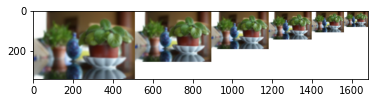

In [469]:
v = MakeLaplacianPyramid('violet.jpg',0.75,100)
p = ReconstructGaussianFromLaplacianPyramid(v)
ShowGaussianPyramid(p)

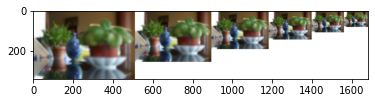

In [470]:
o = MakeLaplacianPyramid('orchid.jpg',0.75,100)
p = ReconstructGaussianFromLaplacianPyramid(o)
ShowGaussianPyramid(p)

# 2.5 
Now construct a Gaussian pyramid of the orchard_mask.bmp image using MakeGaussianPyramid function from Part 1. Visualize the pyramid using ShowGaussianPyramid(pyramid) function from Part 1.

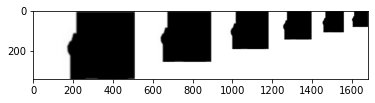

In [471]:
om = MakeLaplacianPyramid('orchid_mask.bmp',0.75,100)
p = ReconstructGaussianFromLaplacianPyramid(om)
ShowGaussianPyramid(p)

# 2.6
In the final step you need to compose the two Laplacian pyramids, level by level, using Gaussian pyramid levels as masks (which must be normalized to be in the 0 to 1 range). You can do this by itterating over Laplacian levels and do the following (per channel):
Division or not division by 255 depends on how you read in the image for the mask.

You should end up with a Laplacian pyramid that contains the output of the blend. Now use the ReconstructGaussianFromLaplacianPyramid function to construct an output Gaussian pyramid and display the highest resolution level, which should correspond exactly to the size of the two input images. Your result should look something like this:

In [505]:
def ComposeTwoPyramids1(maskpy, img1py,img2py):
    # from PIL to image to arraay
    maskarray = []
    for p in maskpy:
        p = p.convert('RGB')
        p = np.asarray(p,dtype="float32")
        maskarray.append(p)
    
    
    # compose two
    compLaplacian = img1py
    a = min(len(maskarray),len(img1py),len(img2py))
    for i in range(a):
#         np.reshape(maskarray[i],(img1py[i].shape[0],img1py[i].shape[1]))
#         print((img1py[i] * maskarray[i]).shape)
#         print((img2py[i] * (np.full(maskarray[i].shape,1) - maskarray[i])).shape)
        compLaplacian[i] = img1py[i] * maskarray[i] + img2py[i] * maskarray[i]
    
    gp = ReconstructGaussianFromLaplacianPyramid(compLaplacian)
    plt.imshow(gp[0])
    return None

def ComposeTwoPyramids2(maskpy, img1py,img2py):
    # from PIL to image to arraay
    maskarray = []
    
    for p in maskpy:
        p = p.convert('RGB')
        p = np.asarray(p,dtype="float32")
        maskarray.append(p)
    
    # compose two
    compLaplacian = img1py
    a = min(len(maskarray),len(img1py),len(img2py))
    for i in range(a):
        compLaplacian[i] = img1py[i] * maskarray[i]/255 + img2py[i] * (1 - maskarray[i]/255)
    
    gp = ReconstructGaussianFromLaplacianPyramid(compLaplacian)
    plt.imshow(gp[0])
    return None

<PIL.Image.Image image mode=RGB size=384x255 at 0x19138DA7EE0>


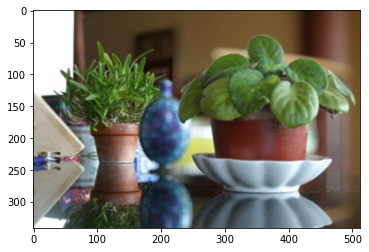

In [516]:
# o = Image.open('orchid.jpg')
# v = Image.open('violet.jpg')
# (x,y) = v.size
# o = o.resize((int(x),int(y)), Image.BICUBIC)
# o.save('orchidnew.jpg')
# mask = mask.resize((int(x),int(y)), Image.BICUBIC)
# mask.save('masknew.jpg')
mask = Image.open('orchid_mask.bmp')
maskpy = MakeGaussianPyramid(mask, 0.75, 300)
print(maskpy[1])
maskarray = []
for p in maskpy:
    p = p.convert('RGB')
    p = np.asarray(p).astype(np.uint8)
    maskarray.append(p)
# print(maskarray[3].shape)
o = MakeLaplacianPyramid('orchid.jpg',0.75,300)
# print(o[2].shape)
v = MakeLaplacianPyramid('violet.jpg',0.75,300)
# print(v[2].shape)
# m1 = o[0] * maskarray[0]
# print(m1.shape)
# print(len(maskpy))
# print(len(o))
# print(len(v))

i = len(o)
ComposeTwoPyramids2(maskpy,o,v)

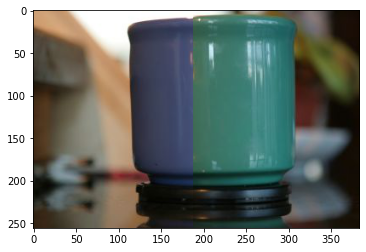

In [518]:
mask = Image.open('cup_mask.bmp')
maskpy = MakeGaussianPyramid(mask, 0.75, 300)

o = MakeLaplacianPyramid('blue_cup.jpg',0.75,300)
v = MakeLaplacianPyramid('green_cup.jpg',0.75,300)

ComposeTwoPyramids2(maskpy,o,v)

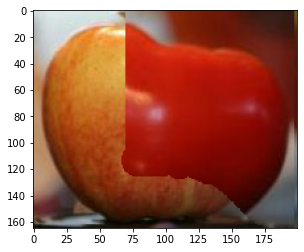

In [517]:
mask = Image.open('tomato_mask.bmp')
maskpy = MakeGaussianPyramid(mask, 0.75, 300)

o = MakeLaplacianPyramid('apple.jpg',0.75,300)
v = MakeLaplacianPyramid('tomato.jpg',0.75,300)

ComposeTwoPyramids2(maskpy,o,v)